# Visualize cross section from the predicted results

In [1]:
import os
import sys 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import seaborn as sns
import scipy.interpolate
import PyQt5
%matplotlib inline

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Global variables

In [25]:
# Specific soil types
assign_num_list = {
                    'soil': 2,
                    'weathered rock': 1,
                    'soft rock': 0,
                  }

labels = {}
for k, v in assign_num_list.items():
    labels[v] = k
    
label_colours = ['black', 'firebrick', 'moccasin']

In [26]:
labels

{2: 'soil', 1: 'weathered rock', 0: 'soft rock'}

### Load data .csv

In [27]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_merged_ntb_tb.csv'

In [28]:
data = pd.read_csv(DATA_DIR)

In [29]:
np.unique(data['Target'])

array([0, 1, 2, 3, 4, 5, 6, 7])

In [30]:
# Convert all to soft rock
data.loc[data['Target']<=2, 'Target'] = 0
# Remain weather rock
data.loc[data['Target']==3, 'Target'] = 1
# Convert all to soil
data.loc[data['Target']>3, 'Target'] = 2

In [31]:
data

,X,Y,Elevation,Target
0,549660.0000,213764.0000,78.00,0
1,549660.0000,213764.0000,83.00,0
2,549660.0000,213764.0000,88.00,0
3,549660.0000,213764.0000,93.00,0
4,549660.0000,213764.0000,98.00,0
...,...,...,...,...
44548,550974.1386,213829.4167,129.75,2
44549,550974.1386,213829.4167,103.65,1
44550,550974.1386,213829.4167,94.85,0
44551,550974.1386,213829.4167,90.55,0


In [32]:
np.unique(data['Target'])

array([0, 1, 2])

### Extract cross section function

In [33]:
def extract_cross_section(inquiry_X = False, inquiry_Y= False, inquiry_elevation = False):
    if inquiry_X:
        print('Process X')
        temp_df = data.loc[data['X'] == inquiry_X]
    elif inquiry_Y:
        print('Process Y')
        temp_df = data.loc[data['Y'] == inquiry_Y]
    elif inquiry_elevation:
        temp_df = data.loc[data['Elevation'] == inquiry_elevation]
    else: 
        temp_df = data

    X = temp_df[['X','Y','Elevation']].to_numpy()
    soil_type = temp_df['Target'].to_numpy()
    return X, soil_type

### Plot functions

In [34]:
def plot_full_3D_points(x, y, labels, colours, train_on = 'ntb'):
    
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(20, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    ax.pbaspect = [2.0, 0.6, 0.25]
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
#         ax.view_init(45, -45)  
        
        if train_on == 'ntb':
            ax.set_title('3D Predicted Points Grid Train on NTB')
        elif train_on == 'tb':
            ax.set_title('3D Predicted Points Grid Train on TB')
        elif train_on == 'merged_ntb_tb':
            ax.set_title('3D Predicted Points Grid Train on merged NTB and TB')

    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
    if train_on == 'ntb':
        plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/3d_points_grid_train_on_NTB.png', dpi=300)
    elif train_on == 'tb':
        plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/3d_points_grid_train_on_TB.png', dpi=300)
    elif train_on == 'merged_ntb_tb':
        plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/3d_points_grid_train_on_merged_NTB_TB.png', dpi=300)
        

In [104]:
def plot_cross_section(X, soil_type, inquiry = 'Y', train_on='ntb'):

    if inquiry == 'Y':
        x = X[:, 0]
    elif inquiry == 'X':
        x = X[:, 1]
        
    y = X[:, 2]
    z = soil_type
    
    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(x.min(), x.max(), 300), np.linspace(y.min(), y.max(), 300)
    xi, yi = np.meshgrid(xi, yi)
    
    rbf = scipy.interpolate.Rbf(x, y, z, function='multiquadric')
    zi = rbf(xi, yi)    
    
    z_int = zi.astype(int)
    
    colors = label_colours

    bounds= [0,1,2,3]
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    if inquiry == 'Y':
        fig = plt.figure(figsize=(30,5))
    elif inquiry == 'X':
        fig = plt.figure(figsize=(7,5))
    
    ax = fig.add_subplot(111)
    
#     plt.imshow(zi, vmin=0, vmax=2, origin='lower',
#                extent=[x.min(), x.max(), y.min(), y.max()],
#               cmap=cmap, norm=norm)
    
    
    if inquiry == 'Y':
        plt.imshow(zi, vmin=0, vmax=2, origin='lower',
                   extent=[900, 1220, y.min(), y.max()])
    elif inquiry == 'X':
        plt.imshow(zi, vmin=0, vmax=2, origin='lower',
                   extent=[x.min(), x.max(), y.min(), y.max()])
    
    ax.set_aspect('auto')
    plt.colorbar()
 
#     positions = (1, 2, 3)
#     labels = ("A", "B", "C")
#     plt.xticks(positions, labels)
    
    if inquiry == 'Y':
        plt.xlabel('X')
        plt.ylabel('Elevation')

#         plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/cross_section_Y.png')
    elif inquiry == 'X':
        plt.xlabel('Y')
        plt.ylabel('Elevation')
#         plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/cross_section_X.png')
        
#     plt.show()

# **Visualize results from model train on NTB**

In [105]:
# INQUIRY_X = 550248
# INQUIRY_Y =  213758 + 5*7

INQUIRY_X = 549653
INQUIRY_Y = 213759

In [106]:
INQUIRY_Y

213759

In [107]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_ntb.csv'
data = pd.read_csv(DATA_DIR)

In [108]:
# Convert all to soft rock
data.loc[data['Target']<=2, 'Target'] = 0
# Remain weather rock
data.loc[data['Target']==3, 'Target'] = 1
# Convert all to soil
data.loc[data['Target']>3, 'Target'] = 2

In [109]:
X, soil_type = extract_cross_section(inquiry_X = False, inquiry_Y= False, inquiry_elevation = False)

In [110]:
np.unique(soil_type)

array([0, 1, 2])

In [111]:
(X.shape[0] - 95 - 105)/12

3696.0833333333335

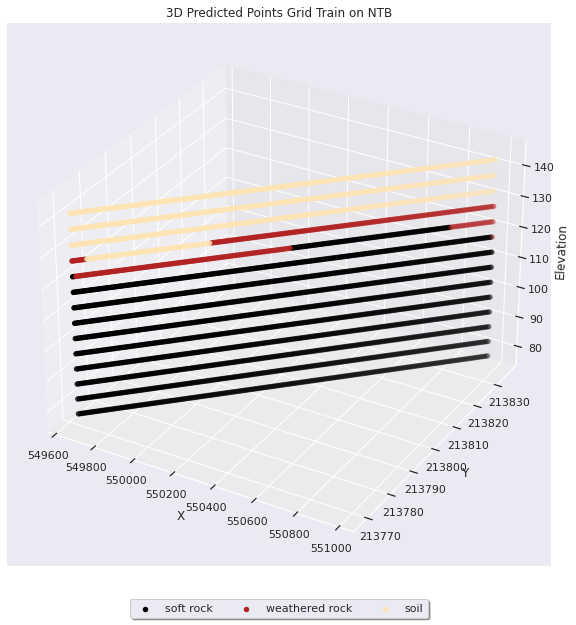

In [112]:
plot_full_3D_points(x = X[3696:3696*2], y = soil_type[3696:3696*2], labels = labels, colours=label_colours, train_on='ntb')

### **Inquiry Y Cross section**

In [113]:
X_cross_Y = X[3696:3696*2]
soil_type_cross_Y = soil_type[3696:3696*2]

In [114]:
X_cross_Y[:,0].max() - X_cross_Y[:,0].min()

1315.0

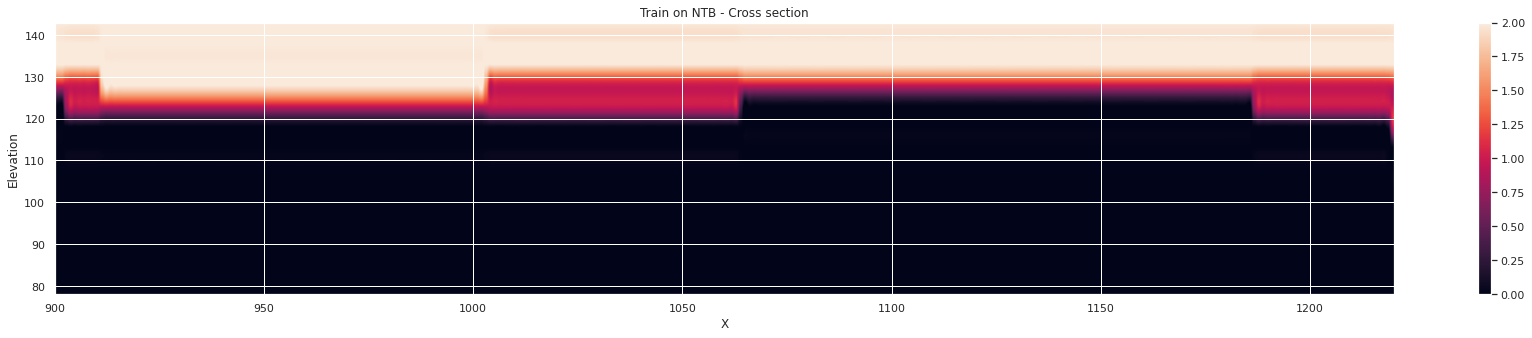

In [115]:
plot_cross_section(X_cross_Y, soil_type_cross_Y, inquiry = 'Y')
plt.title('Train on NTB - Cross section')
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/cross_section_Y_ntb.png', dpi=300)
plt.show()

### **Inquiry X Cross section**

In [23]:
# X_cross_X, soil_type_cross_X = extract_cross_section(inquiry_X = INQUIRY_X)

In [24]:
# plot_cross_section(X_cross_X, soil_type_cross_X, inquiry = 'X')
# plt.title('Train on NTB - Cross section at X = {}'.format(INQUIRY_X))
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/cross_section_X_ntb.png', dpi=300)

# **Visualize results from model train on TB**

In [25]:
# DATA_DIR = '/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_tb.csv'
# data = pd.read_csv(DATA_DIR)

In [26]:
# X, soil_type = extract_cross_section(inquiry_X = False, inquiry_Y= False, inquiry_elevation = False)

In [27]:
# plot_full_3D_points(x = X, y = soil_type, labels = labels, colours=label_colours, train_on='tb')

### **Inquiry Y Cross section**

In [28]:
# X_cross_Y, soil_type_cross_Y = extract_cross_section(inquiry_Y = INQUIRY_Y)

In [29]:
# plot_cross_section(X_cross_Y, soil_type_cross_Y, inquiry = 'Y')
# plt.title('Train on TB - Cross section at Y = {}'.format(INQUIRY_Y))
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/cross_section_Y_tb.png', dpi=300)


### **Inquiry X Cross section**

In [30]:
# X_cross_X, soil_type_cross_X = extract_cross_section(inquiry_X = INQUIRY_X)

In [31]:
# plot_cross_section(X_cross_X, soil_type_cross_X, inquiry = 'X')
# plt.title('Train on TB - Cross section at X = {}'.format(INQUIRY_X))
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/cross_section_X_tb.png', dpi=300)

# **Visualize results from model train on merged NTB and TB**

In [116]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_merged_ntb_tb.csv'
data = pd.read_csv(DATA_DIR)

In [117]:
# Convert all to soft rock
data.loc[data['Target']<=2, 'Target'] = 0
# Remain weather rock
data.loc[data['Target']==3, 'Target'] = 1
# Convert all to soil
data.loc[data['Target']>3, 'Target'] = 2

In [118]:
X, soil_type = extract_cross_section(inquiry_X = False, inquiry_Y= False, inquiry_elevation = False)

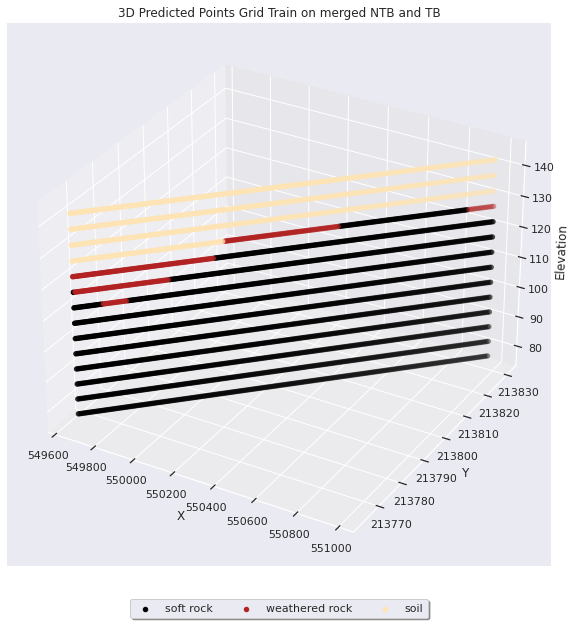

In [119]:
plot_full_3D_points(x = X[:3696], y = soil_type[:3696], labels = labels, colours=label_colours, train_on='merged_ntb_tb')

### **Inquiry Y Cross section**

In [120]:
# INQUIRY_Y =  213759 + 5*10

In [121]:
# X_cross_Y, soil_type_cross_Y = extract_cross_section(inquiry_Y = INQUIRY_Y)

In [122]:
X_cross_Y = X[3696:3696*2]
soil_type_cross_Y = soil_type[3696:3696*2]

Text(0.5, 1.0, 'Train on NTB and TB - Cross section at Y = 213759')

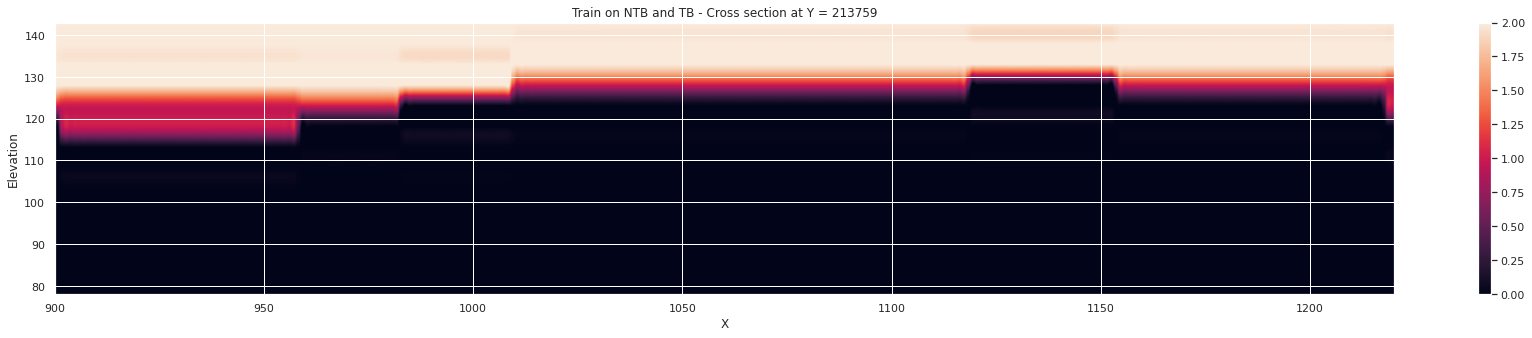

In [123]:
plot_cross_section(X_cross_Y, soil_type_cross_Y, inquiry = 'Y')
plt.title('Train on NTB and TB - Cross section at Y = {}'.format(INQUIRY_Y))
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/cross_section_Y_ntb_tb.png', dpi=300)


### **Inquiry X Cross section**

In [124]:
X_cross_X, soil_type_cross_X = extract_cross_section(inquiry_X = 549660)

Process X


Text(0.5, 1.0, 'Train on NTB and TB - Cross section at X = 549653')

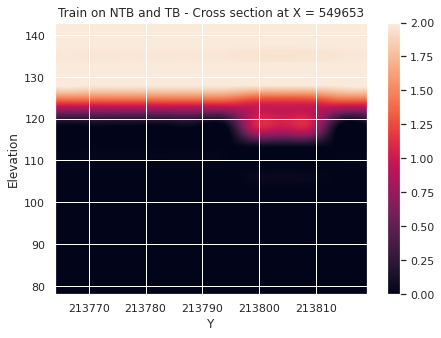

In [125]:
plot_cross_section(X_cross_X, soil_type_cross_X, inquiry = 'X')
plt.title('Train on NTB and TB - Cross section at X = {}'.format(INQUIRY_X))
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/cross_section_X_ntb_tb.png', dpi=300)